# GPT-5.2 Vision Baseline — Few-Shot
Few-shot handwritten math → LaTeX using `gpt-5.2`.

Set `OPENAI_API_KEY` in your environment before running.

In [1]:
import os, json, re, time, base64, random
from io import BytesIO

import matplotlib.pyplot as plt
from openai import OpenAI
from datasets import load_dataset

api_key = os.getenv("OPENAI_API_KEY")
assert api_key, "Set the OPENAI_API_KEY environment variable before running."
client = OpenAI(api_key=api_key)
print("OpenAI client ready.")

OpenAI client ready.


Train: 229864, Test: 7644


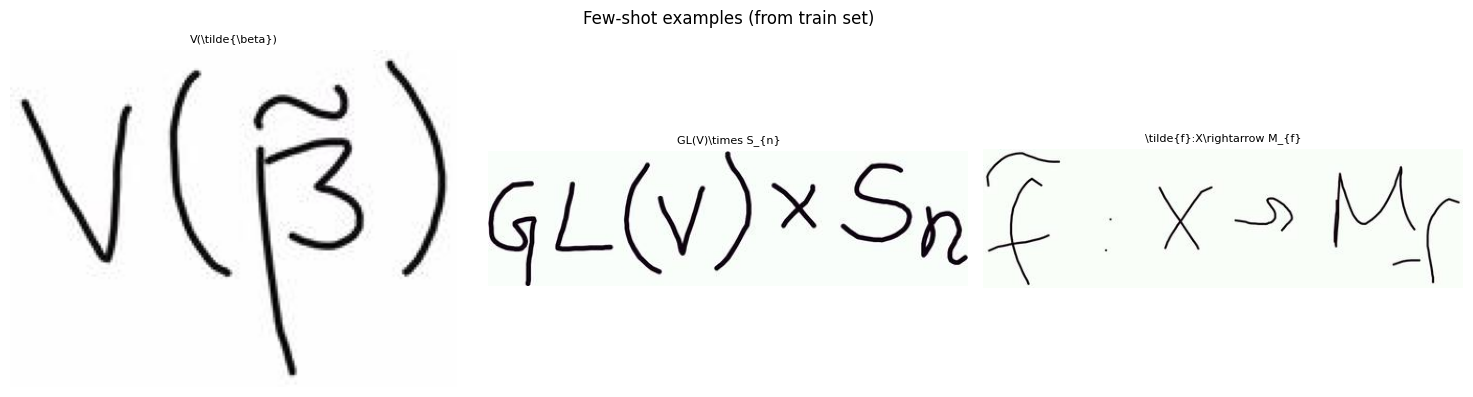

In [2]:
MODEL = "gpt-5.2"
NUM_FEW_SHOT = 3
NUM_SAMPLES = 50
SEED = 42
DELAY_BETWEEN_CALLS = 0.5

# Load both splits: train for few-shot examples, test for evaluation
ds = load_dataset("deepcopy/MathWriting-human")
print(f"Train: {len(ds['train'])}, Test: {len(ds['test'])}")

# Few-shot: first 3 samples from train set
few_shot_samples = [ds["train"][i] for i in range(NUM_FEW_SHOT)]

# Eval: 50 random samples from test set
random.seed(SEED)
test_indices = random.sample(range(len(ds["test"])), NUM_SAMPLES)
test_samples = [ds["test"][i] for i in test_indices]

# Encode few-shot images to base64 once — reused on every API call
def encode_image(pil_image):
    buf = BytesIO()
    pil_image.save(buf, format="PNG")
    return base64.b64encode(buf.getvalue()).decode("utf-8")

few_shot_b64 = [(encode_image(s["image"]), s["latex"]) for s in few_shot_samples]

# Preview few-shot examples
fig, axes = plt.subplots(1, NUM_FEW_SHOT, figsize=(5 * NUM_FEW_SHOT, 4))
for ax, s in zip(axes, few_shot_samples):
    ax.imshow(s["image"], cmap="gray")
    ax.set_title(s["latex"][:50], fontsize=8)
    ax.axis("off")
plt.suptitle("Few-shot examples (from train set)", fontsize=12)
plt.tight_layout()
plt.show()

In [3]:
SYSTEM_PROMPT = (
    "You are an expert at reading handwritten mathematical equations and converting them to LaTeX. "
    "When given an image of a handwritten equation, return ONLY the raw LaTeX markup. "
    "Do not include dollar signs, \\begin{equation}, explanation text, or code fences. "
    "Return just the LaTeX string, nothing else."
)

USER_QUERY = "Convert this handwritten equation to LaTeX:"


def strip_code_fences(text):
    return re.sub(r"^```(?:latex)?\n?|\n?```$", "", text, flags=re.MULTILINE).strip()


def predict_latex(pil_image):
    """Build few-shot multi-turn input (3 train examples) then query the model."""
    messages = []
    for b64, latex in few_shot_b64:
        messages.append({
            "role": "user",
            "content": [
                {"type": "input_text", "text": USER_QUERY},
                {"type": "input_image", "image_url": f"data:image/png;base64,{b64}"},
            ],
        })
        messages.append({"role": "assistant", "content": latex})
    # Test query
    b64_test = encode_image(pil_image)
    messages.append({
        "role": "user",
        "content": [
            {"type": "input_text", "text": USER_QUERY},
            {"type": "input_image", "image_url": f"data:image/png;base64,{b64_test}"},
        ],
    })
    response = client.responses.create(
        model=MODEL,
        instructions=SYSTEM_PROMPT,
        input=messages,
    )
    return strip_code_fences(response.output_text.strip())


def normalized_edit_distance(pred, target):
    m, n = len(pred), len(target)
    if m == 0 and n == 0:
        return 0.0
    dp = list(range(n + 1))
    for i in range(1, m + 1):
        prev = dp[0]
        dp[0] = i
        for j in range(1, n + 1):
            temp = dp[j]
            dp[j] = prev if pred[i-1] == target[j-1] else 1 + min(dp[j], dp[j-1], prev)
            prev = temp
    return dp[n] / max(m, n)

In [4]:
results = []
exact_matches = 0
total_edit_dist = 0.0

print(f"Evaluating {NUM_SAMPLES} test samples ({NUM_FEW_SHOT}-shot, model={MODEL})...")
print("-" * 60)

for i, sample in enumerate(test_samples):
    ground_truth = sample["latex"]
    try:
        prediction = predict_latex(sample["image"])
    except Exception as e:
        print(f"  [{i+1}/{NUM_SAMPLES}] ERROR: {e}")
        prediction = ""

    is_exact = prediction == ground_truth
    edit_dist = normalized_edit_distance(prediction, ground_truth)

    if is_exact:
        exact_matches += 1
    total_edit_dist += edit_dist

    results.append({
        "index": test_indices[i],
        "ground_truth": ground_truth,
        "prediction": prediction,
        "exact_match": is_exact,
        "normalized_edit_distance": round(edit_dist, 4),
    })

    status = "EXACT" if is_exact else f"edit_dist={edit_dist:.4f}"
    print(f"  [{i+1:2d}/{NUM_SAMPLES}] {status}")
    print(f"    GT:   {ground_truth[:80]}")
    print(f"    PRED: {prediction[:80]}")
    print("-" * 40)

    if i < NUM_SAMPLES - 1:
        time.sleep(DELAY_BETWEEN_CALLS)

accuracy = exact_matches / NUM_SAMPLES
avg_edit_dist = total_edit_dist / NUM_SAMPLES

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"Model:                    {MODEL}")
print(f"Few-shot examples:        {NUM_FEW_SHOT}")
print(f"Samples:                  {NUM_SAMPLES}")
print(f"Exact match accuracy:     {accuracy:.2%} ({exact_matches}/{NUM_SAMPLES})")
print(f"Avg normalized edit dist: {avg_edit_dist:.4f}")

with open("gpt52_baseline_results.json", "w") as f:
    json.dump({
        "summary": {
            "model": MODEL,
            "num_few_shot": NUM_FEW_SHOT,
            "num_samples": NUM_SAMPLES,
            "seed": SEED,
            "exact_match_accuracy": round(accuracy, 4),
            "avg_normalized_edit_distance": round(avg_edit_dist, 4),
        },
        "results": results,
    }, f, indent=2)
print("Results saved to gpt52_baseline_results.json")

Evaluating 50 test samples (3-shot, model=gpt-5.2)...
------------------------------------------------------------
  [ 1/50] edit_dist=0.3478
    GT:   WA_{k}=TH_{k}*FF
    PRED: WA_{k}=T_{H_{k}}\ast FF
----------------------------------------
  [ 2/50] edit_dist=0.5135
    GT:   tr_{B}(|\psi\rangle\langle\psi|)=\rho
    PRED: -I_{B}(\psi)\langle\psi|\rangle=p
----------------------------------------
  [ 3/50] edit_dist=0.1538
    GT:   O(\sqrt{b-a})
    PRED: o(\sqrt{b-q})
----------------------------------------
  [ 4/50] edit_dist=0.0250
    GT:   \sigma=|c|\frac{\Delta t}{\Delta x}\in N
    PRED: \sigma=|u|\frac{\Delta t}{\Delta x}\in N
----------------------------------------
  [ 5/50] edit_dist=0.2432
    GT:   \chi=\frac{n\mu_{0}\mu^{2}}{3k_{B}T}
    PRED: \lambda=\frac{nN_{0}\mu^{2}}{3k_{B}T}
----------------------------------------
  [ 6/50] edit_dist=0.1667
    GT:   U=\frac{1}{R}=\frac{\dot{Q}_{A}}{\Delta T}=\frac{k}{L}
    PRED: U=\frac{1}{R}=\frac{QA}{\Delta T}=\frac{k}{L}